In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set_theme(style="whitegrid")
pd.set_option('display.max_rows', 100)

print("--- Notebook 6: Policy Impact Analysis ---")

# --- 1. Define Paths ---
# Paths are relative to the 'notebooks' directory (one level up to the root)
ROOT_DIR = ".."
RESULTS_PATH = os.path.join(ROOT_DIR, "data", "processed", "policy_impact_database_V2_local.csv")
FEATURES_PATH = os.path.join(ROOT_DIR, "data", "processed", "india_policies_featurized_local.csv")

# --- 2. Load Data ---
try:
    df_results = pd.read_csv(RESULTS_PATH)
    df_features = pd.read_csv(FEATURES_PATH)
    
    print(f"✅ Successfully loaded {len(df_results)} ATE results.")
    print(f"✅ Successfully loaded {len(df_features)} policy features.")
    
except FileNotFoundError as e:
    print(f"❌ ERROR: Could not find data files. Please check paths relative to the 'notebooks' directory.")
    print(e)

# --- 3. Initial Inspection ---
print("\n--- Results Database Head ---")
display(df_results.head())

print("\n--- Features Database Head (for merging) ---")
# We only need a few columns for merging
df_features_slim = df_features[['Policy', 'policy_type', 'action_type', 'Year']].copy()
display(df_features_slim.head())

--- Notebook 6: Policy Impact Analysis ---
✅ Successfully loaded 9648 ATE results.
✅ Successfully loaded 603 policy features.

--- Results Database Head ---


,policy,policy_year,pollutant,ate,p_value_ate,p_value_placebo
0,National Building Code of India 2016 (vol I an...,1970,EDGAR_BC_1970_2022,-1840.9449,0.0000,0.0
1,National Building Code of India 2016 (vol I an...,1970,EDGAR_CO_1970_2022,-88065.6252,0.0000,0.0
2,National Building Code of India 2016 (vol I an...,1970,EDGAR_NH3_1970_2022,-7394.7556,0.0180,0.0
3,National Building Code of India 2016 (vol I an...,1970,EDGAR_NMVOC_1970_2022,-7825.9830,0.0002,0.0
4,National Building Code of India 2016 (vol I an...,1970,EDGAR_NOx_1970_2022,-11576.4264,0.0003,0.0



--- Features Database Head (for merging) ---


,Policy,policy_type,action_type,Year
0,National Building Code of India 2016 (vol I an...,BuildingCode,Regulation,1970
1,Himachal Pradesh Forest (Sale of Timber) Rules...,Forestry,Regulation,1970
2,Agreement establishing the Pepper Community,Agriculture,Cooperation,1971
3,Convention on Wetlands of International Import...,WaterManagement,Regulation,1971
4,"Coking Coal Mines (Emergency Provisions) Act, ...",Industrial,Regulation,1971


In [2]:
# --- 4. Define Significance Thresholds ---
P_VALUE_ATE_THRESHOLD = 0.05  # Standard for statistical significance (p < 0.05)
P_VALUE_PLACEBO_THRESHOLD = 0.1 # Our custom robustness check (p > 0.1 would be suspect)

# --- 5. Filter for "Effective" Policies ---
# An "effective" result is one that:
# 1. Reduced pollution (ate < 0)
# 2. Was statistically significant (p_value_ate < 0.05)
# 3. Passed the robustness test (p_value_placebo < 0.1)

df_effective = df_results[
    (df_results['ate'] < 0) &
    (df_results['p_value_ate'] < P_VALUE_ATE_THRESHOLD) &
    (df_results['p_value_placebo'] < P_VALUE_PLACEBO_THRESHOLD)
].copy()

print(f"Found {len(df_effective)} policy/pollutant pairs that show a significant, robust reduction in emissions.")

# Sort by the strongest effect (most negative ATE)
df_top_pairs = df_effective.sort_values(by='ate', ascending=True)

print("\n--- Top 10 Most Effective Policy/Pollutant Pairs (by ATE magnitude) ---")
display(df_top_pairs[['policy', 'pollutant', 'ate', 'p_value_ate']].head(10))

Found 20 policy/pollutant pairs that show a significant, robust reduction in emissions.

--- Top 10 Most Effective Policy/Pollutant Pairs (by ATE magnitude) ---


,policy,pollutant,ate,p_value_ate
1,National Building Code of India 2016 (vol I an...,EDGAR_CO_1970_2022,-88065.6252,0.0000
17,Himachal Pradesh Forest (Sale of Timber) Rules...,EDGAR_CO_1970_2022,-88065.6252,0.0000
8,National Building Code of India 2016 (vol I an...,EDGAR_SO2_1970_2022,-34049.0373,0.0000
24,Himachal Pradesh Forest (Sale of Timber) Rules...,EDGAR_SO2_1970_2022,-34049.0373,0.0000
20,Himachal Pradesh Forest (Sale of Timber) Rules...,EDGAR_NOx_1970_2022,-11576.4264,0.0003
4,National Building Code of India 2016 (vol I an...,EDGAR_NOx_1970_2022,-11576.4264,0.0003
22,Himachal Pradesh Forest (Sale of Timber) Rules...,EDGAR_PM10_1970_2022,-11320.4950,0.0000
6,National Building Code of India 2016 (vol I an...,EDGAR_PM10_1970_2022,-11320.4950,0.0000
19,Himachal Pradesh Forest (Sale of Timber) Rules...,EDGAR_NMVOC_1970_2022,-7825.9830,0.0002
3,National Building Code of India 2016 (vol I an...,EDGAR_NMVOC_1970_2022,-7825.9830,0.0002


In [3]:
# --- 6. Merge Effective Results with Features ---
# We use a 'left' merge to keep all our effective results and add the features
# We merge 'policy' (from results) with 'Policy' (from features)
df_merged = df_effective.merge(
    df_features_slim,
    left_on='policy',
    right_on='Policy',
    how='left'
)

# Clean up the merged DataFrame
df_merged = df_merged.drop(columns=['Policy']) # Drop the redundant 'Policy' column
df_merged = df_merged.dropna(subset=['policy_type', 'action_type']) # Drop any rows that failed to merge

print("✅ Merged effective results with policy features.")
print(f"   Remaining results after merge: {len(df_merged)}")

print("\n--- Head of Merged Dataframe ---")
display(df_merged[['policy', 'pollutant', 'ate', 'policy_type', 'action_type']].head())

✅ Merged effective results with policy features.
   Remaining results after merge: 20

--- Head of Merged Dataframe ---


,policy,pollutant,ate,policy_type,action_type
0,National Building Code of India 2016 (vol I an...,EDGAR_BC_1970_2022,-1840.9449,BuildingCode,Regulation
1,National Building Code of India 2016 (vol I an...,EDGAR_CO_1970_2022,-88065.6252,BuildingCode,Regulation
2,National Building Code of India 2016 (vol I an...,EDGAR_NH3_1970_2022,-7394.7556,BuildingCode,Regulation
3,National Building Code of India 2016 (vol I an...,EDGAR_NMVOC_1970_2022,-7825.9830,BuildingCode,Regulation
4,National Building Code of India 2016 (vol I an...,EDGAR_NOx_1970_2022,-11576.4264,BuildingCode,Regulation


In [4]:
# --- 7. Analyze by Policy Type ---
print("--- 📊 Analysis by Policy Type ---")

# Calculate the average ATE for each policy type
avg_ate_by_type = df_merged.groupby('policy_type')['ate'].mean().sort_values(ascending=True)

print("\n--- Average ATE by Policy Type (Lower is better) ---")
display(avg_ate_by_type)

# Count how many significant reductions each policy type was responsible for
count_by_type = df_merged['policy_type'].value_counts()

print("\n--- Count of Significant Reductions by Policy Type ---")
display(count_by_type)


# --- 8. Analyze by Action Type ---
print("\n\n--- 📊 Analysis by Action Type ---")

# Calculate the average ATE for each action type
avg_ate_by_action = df_merged.groupby('action_type')['ate'].mean().sort_values(ascending=True)

print("\n--- Average ATE by Action Type (Lower is better) ---")
display(avg_ate_by_action)

# Count how many significant reductions each action type was responsible for
count_by_action = df_merged['action_type'].value_counts()

print("\n--- Count of Significant Reductions by Action Type ---")
display(count_by_action)

--- 📊 Analysis by Policy Type ---

--- Average ATE by Policy Type (Lower is better) ---


policy_type
BuildingCode   -17575.49996
Forestry       -17575.49996
Name: ate, dtype: float64


--- Count of Significant Reductions by Policy Type ---


policy_type
BuildingCode    10
Forestry        10
Name: count, dtype: int64



--- 📊 Analysis by Action Type ---

--- Average ATE by Action Type (Lower is better) ---


action_type
Regulation   -17575.49996
Name: ate, dtype: float64


--- Count of Significant Reductions by Action Type ---


action_type
Regulation    20
Name: count, dtype: int64

In [5]:
# --- 9. Investigate the 20 Filtered Results ---
print("--- Investigating the 20 Effective Results ---")
print("Are these all for the same policy or policies enacted in the same year?")

# We sort by policy and then pollutant to see what they are.
display(
    df_merged[['policy', 'policy_year', 'pollutant', 'ate', 'policy_type', 'action_type']]
    .sort_values(by=['policy', 'pollutant'])
)

--- Investigating the 20 Effective Results ---
Are these all for the same policy or policies enacted in the same year?


,policy,policy_year,pollutant,ate,policy_type,action_type
10,Himachal Pradesh Forest (Sale of Timber) Rules...,1970,EDGAR_BC_1970_2022,-1840.9449,Forestry,Regulation
11,Himachal Pradesh Forest (Sale of Timber) Rules...,1970,EDGAR_CO_1970_2022,-88065.6252,Forestry,Regulation
12,Himachal Pradesh Forest (Sale of Timber) Rules...,1970,EDGAR_NH3_1970_2022,-7394.7556,Forestry,Regulation
13,Himachal Pradesh Forest (Sale of Timber) Rules...,1970,EDGAR_NMVOC_1970_2022,-7825.9830,Forestry,Regulation
14,Himachal Pradesh Forest (Sale of Timber) Rules...,1970,EDGAR_NOx_1970_2022,-11576.4264,Forestry,Regulation
15,Himachal Pradesh Forest (Sale of Timber) Rules...,1970,EDGAR_OC_1970_2022,-6835.4482,Forestry,Regulation
16,Himachal Pradesh Forest (Sale of Timber) Rules...,1970,EDGAR_PM10_1970_2022,-11320.4950,Forestry,Regulation
17,Himachal Pradesh Forest (Sale of Timber) Rules...,1970,EDGAR_PM2,-6846.2770,Forestry,Regulation
18,Himachal Pradesh Forest (Sale of Timber) Rules...,1970,EDGAR_SO2_1970_2022,-34049.0373,Forestry,Regulation
19,Himachal Pradesh Forest (Sale of Timber) Rules...,1970,PCB_1970_2018,-0.0070,Forestry,Regulation


In [6]:
# --- 10. Widen Filter to find more results ---
# Let's *only* filter for a significant reduction and ignore the placebo test for now.
df_effective_broad = df_results[
    (df_results['ate'] < 0) &
    (df_results['p_value_ate'] < P_VALUE_ATE_THRESHOLD)
].copy()

print(f"--- Found {len(df_effective_broad)} significant results (ignoring placebo test) ---")

# Now let's merge this broader set with the features
df_merged_broad = df_effective_broad.merge(
    df_features_slim,
    left_on='policy',
    right_on='Policy',
    how='left'
)
df_merged_broad = df_merged_broad.dropna(subset=['policy_type'])

# --- 11. Re-analyze with Broader Data ---
print("\n--- 📊 Broader Analysis by Policy Type (Count) ---")
print("This shows all policy types that had *any* significant effect.")
display(df_merged_broad['policy_type'].value_counts())

print("\n--- 📊 Broader Analysis by Policy Type (Average ATE) ---")
display(df_merged_broad.groupby('policy_type')['ate'].mean().sort_values())

--- Found 1118 significant results (ignoring placebo test) ---

--- 📊 Broader Analysis by Policy Type (Count) ---
This shows all policy types that had *any* significant effect.


policy_type
EnergyEfficiency               261
Forestry                       155
Agriculture                     61
AirQualityStandard              58
Mining                          58
WaterManagement                 55
RenewableEnergy                 53
Framework                       37
Transport                       32
Industrial                      31
EnvironmentalRegulation         26
ElectricityRegulation           20
WasteManagement                 18
Environment                     18
Cooperative                     14
GovernanceStructure             13
Other                           10
BuildingCode                    10
UrbanPlanning                    9
ConsumerProtection               9
LegalFramework                   9
EnergyEnergy                     9
Infrastructure                   9
LandRevenueAdministration        9
OilAndGas                        9
EnergyManagement                 9
IntellectualProperty             9
EnergyRegulation                 9
Environm


--- 📊 Broader Analysis by Policy Type (Average ATE) ---


policy_type
BuildingCode                  -17575.499960
Forestry                       -1162.286975
EconomicPartnership              -90.251100
NuclearEnergy                    -90.251100
SpaceExploration                 -56.041400
CulturalHeritage                 -53.718250
EnergyExploration                -48.553900
ClimateChange                    -48.553900
LandAcquisition                  -48.553900
SustainableDevelopment           -48.553900
RenewableEnergy                  -39.756538
EnergyInfrastructure             -38.522388
Framework                        -37.191103
Other                            -37.182240
WasteManagement                  -37.074978
Industrial                       -36.946913
ConsumerProtection               -36.624111
LandRevenueAdministration        -36.624111
Transport                        -35.355762
Environment                      -35.215839
AirQualityStandard               -35.083881
Mining                           -34.660357
Infrastructure      

In [7]:
# --- 12. Re-analyze by Policy Type (using MEDIAN) ---
# Median is more robust to extreme outliers (like 'BuildingCode')
print("--- 📊 Analysis by Policy Type (MEDIAN ATE) ---")
print("This shows the 'typical' ATE for a policy type.")

# We will use our 'df_merged_broad' (all significant results)
median_ate_by_type = df_merged_broad.groupby('policy_type')['ate'].median().sort_values(ascending=True)
display(median_ate_by_type)

# --- 13. Re-analyze by Action Type (using MEDIAN) ---
print("\n--- 📊 Analysis by Action Type (MEDIAN ATE) ---")
median_ate_by_action = df_merged_broad.groupby('action_type')['ate'].median().sort_values(ascending=True)
display(median_ate_by_action)

--- 📊 Analysis by Policy Type (MEDIAN ATE) ---
This shows the 'typical' ATE for a policy type.


policy_type
BuildingCode                  -7610.36930
EconomicPartnership             -90.25110
NuclearEnergy                   -90.25110
SpaceExploration                -56.04140
CulturalHeritage                -53.71825
LandAcquisition                 -48.55390
EnergyExploration               -48.55390
ClimateChange                   -48.55390
SustainableDevelopment          -48.55390
RenewableEnergy                 -26.52260
Framework                       -23.25830
Industrial                      -23.25830
WasteManagement                 -22.68570
MarketRegulation                -22.61670
EnergyInfrastructure            -22.41310
ConsumerProtection              -22.15210
LandRevenueAdministration       -22.15210
UrbanPlanning                   -21.54750
Mining                          -20.90780
EnergyRegulation                -20.26810
LegalFramework                  -20.26810
OilAndGas                       -20.26810
IntellectualProperty            -20.26810
Transport             


--- 📊 Analysis by Action Type (MEDIAN ATE) ---


action_type
Incentive                                   -48.55390
R&D                                         -48.55390
PolicyDeclaration                           -48.55390
Regulation and Investment                   -48.55390
Standard                                    -48.55390
Cooperation                                 -24.81080
CooperationAgreement                        -22.64780
Treaty                                      -21.83170
AwardProgram                                -20.26810
Nationalisation                             -19.62700
TaxIncentive                                -19.08375
InformationPublication                      -18.89650
Investment                                  -18.89650
Guideline                                   -18.89650
General                                     -18.89650
Guidebook                                   -18.89650
Strategy                                    -18.89650
Resource                                    -18.89650
Regulation      

C:\Users\VIRAJ\AppData\Local\Temp\ipykernel_18112\1134829911.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


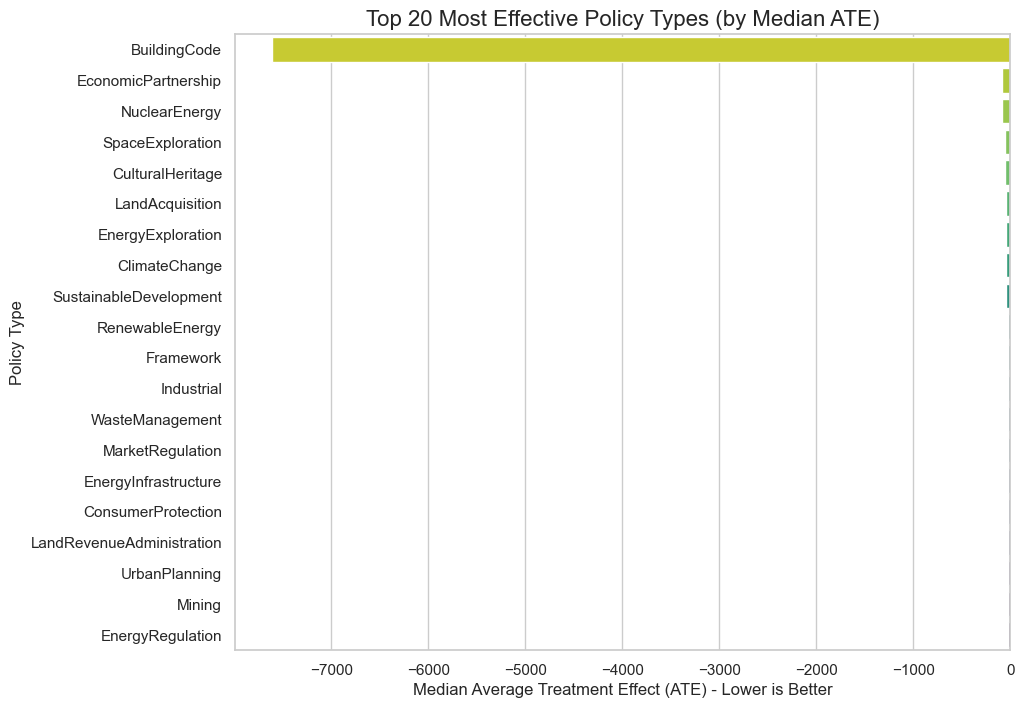

C:\Users\VIRAJ\AppData\Local\Temp\ipykernel_18112\1134829911.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


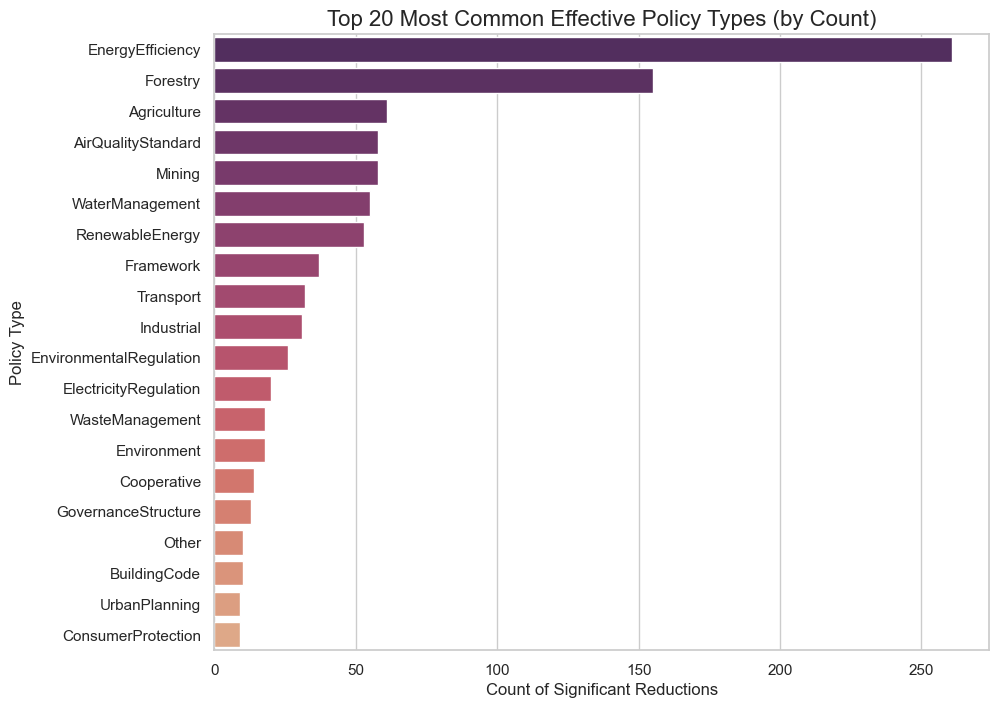

In [8]:
# --- 14. Visualize: Average ATE by Policy Type ---
# Let's plot the median ATEs we just calculated

# Get the top 20 most effective types (by median)
data_to_plot = median_ate_by_type.head(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=data_to_plot.values, 
    y=data_to_plot.index, 
    palette="viridis_r" # 'r' reverses the colormap (green = good)
)
plt.title('Top 20 Most Effective Policy Types (by Median ATE)', fontsize=16)
plt.xlabel('Median Average Treatment Effect (ATE) - Lower is Better', fontsize=12)
plt.ylabel('Policy Type', fontsize=12)
plt.show()

# --- 15. Visualize: Count of Effective Policies ---
# This shows us which types of policies are *most common* in our effective list
count_to_plot = df_merged_broad['policy_type'].value_counts().head(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=count_to_plot.values,
    y=count_to_plot.index,
    palette="flare_r"
)
plt.title('Top 20 Most Common Effective Policy Types (by Count)', fontsize=16)
plt.xlabel('Count of Significant Reductions', fontsize=12)
plt.ylabel('Policy Type', fontsize=12)
plt.show()

In [9]:
# --- 16. Deep Dive: Investigate the 'BuildingCode' Outlier ---
print("--- 🔎 Deep Dive: What is the 'BuildingCode' policy? ---")

# Filter our significant results (df_merged_broad) for just this type
df_building_code = df_merged_broad[
    df_merged_broad['policy_type'] == 'BuildingCode'
].sort_values(by='ate')

# Display all of them (it should be a small number based on Chart 2)
display(df_building_code[['policy', 'pollutant', 'ate', 'policy_year', 'p_value_ate', 'p_value_placebo']])

print(f"\nThis policy type was associated with {len(df_building_code)} significant reductions.")

--- 🔎 Deep Dive: What is the 'BuildingCode' policy? ---


,policy,pollutant,ate,policy_year,p_value_ate,p_value_placebo
1,National Building Code of India 2016 (vol I an...,EDGAR_CO_1970_2022,-88065.6252,1970,0.0000,0.0
8,National Building Code of India 2016 (vol I an...,EDGAR_SO2_1970_2022,-34049.0373,1970,0.0000,0.0
4,National Building Code of India 2016 (vol I an...,EDGAR_NOx_1970_2022,-11576.4264,1970,0.0003,0.0
6,National Building Code of India 2016 (vol I an...,EDGAR_PM10_1970_2022,-11320.4950,1970,0.0000,0.0
3,National Building Code of India 2016 (vol I an...,EDGAR_NMVOC_1970_2022,-7825.9830,1970,0.0002,0.0
2,National Building Code of India 2016 (vol I an...,EDGAR_NH3_1970_2022,-7394.7556,1970,0.0180,0.0
7,National Building Code of India 2016 (vol I an...,EDGAR_PM2,-6846.2770,1970,0.0000,0.0
5,National Building Code of India 2016 (vol I an...,EDGAR_OC_1970_2022,-6835.4482,1970,0.0000,0.0
0,National Building Code of India 2016 (vol I an...,EDGAR_BC_1970_2022,-1840.9449,1970,0.0000,0.0
9,National Building Code of India 2016 (vol I an...,PCB_1970_2018,-0.0070,1970,0.0066,0.0



This policy type was associated with 10 significant reductions.


--- 📊 Visualizing the 'Top 19' (Excluding BuildingCode) ---


C:\Users\VIRAJ\AppData\Local\Temp\ipykernel_18112\3154464113.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


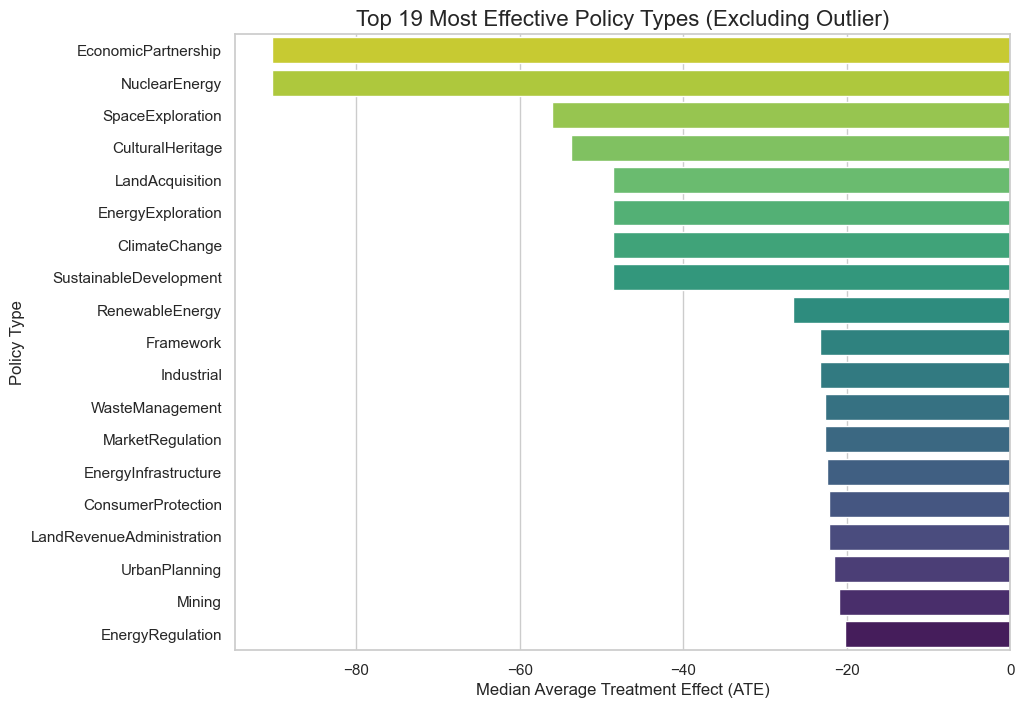

In [10]:
# --- 17. Visualize: Median ATE (Excluding Outlier) ---
print("--- 📊 Visualizing the 'Top 19' (Excluding BuildingCode) ---")

# We use the 'median_ate_by_type' series we already have
# Just .drop() the outlier and take the new top 19
data_to_plot_zoomed = median_ate_by_type.drop('BuildingCode').head(19)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=data_to_plot_zoomed.values, 
    y=data_to_plot_zoomed.index, 
    palette="viridis_r"
)
plt.title('Top 19 Most Effective Policy Types (Excluding Outlier)', fontsize=16)
plt.xlabel('Median Average Treatment Effect (ATE)', fontsize=12)
plt.ylabel('Policy Type', fontsize=12)
plt.show()

C:\Users\VIRAJ\AppData\Local\Temp\ipykernel_18112\4137429156.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


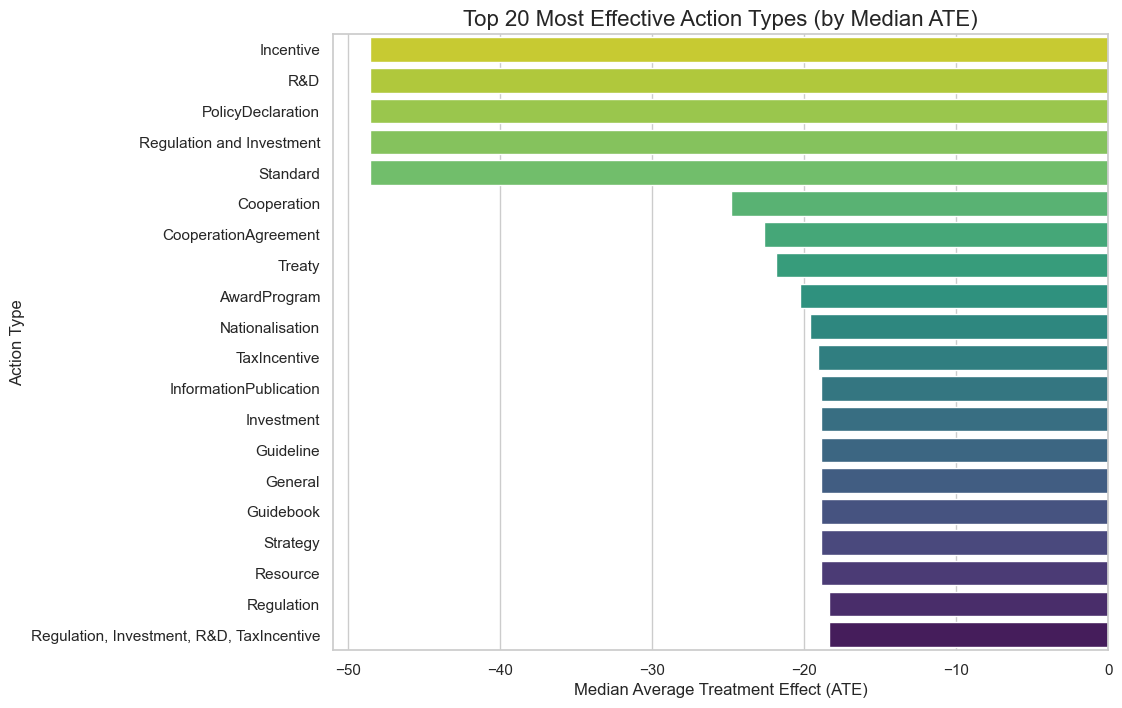

C:\Users\VIRAJ\AppData\Local\Temp\ipykernel_18112\4137429156.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


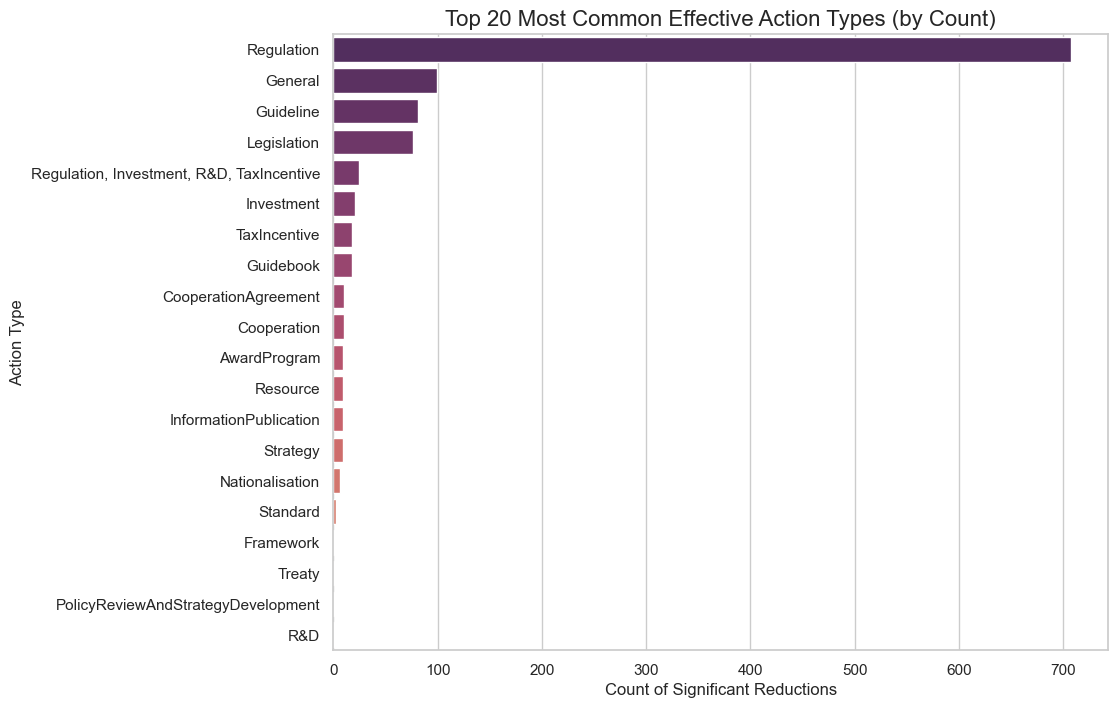

In [11]:
# --- 18. Visualize: Median ATE by Action Type ---
# We already calculated 'median_ate_by_action' in Cell 7
# Let's plot the top 20
data_to_plot_action = median_ate_by_action.head(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=data_to_plot_action.values, 
    y=data_to_plot_action.index, 
    palette="viridis_r"
)
plt.title('Top 20 Most Effective Action Types (by Median ATE)', fontsize=16)
plt.xlabel('Median Average Treatment Effect (ATE)', fontsize=12)
plt.ylabel('Action Type', fontsize=12)
plt.show()

# --- 19. Visualize: Count of Effective Action Types ---
# We use the 'df_merged_broad' dataframe
count_to_plot_action = df_merged_broad['action_type'].value_counts().head(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    x=count_to_plot_action.values,
    y=count_to_plot_action.index,
    palette="flare_r"
)
plt.title('Top 20 Most Common Effective Action Types (by Count)', fontsize=16)
plt.xlabel('Count of Significant Reductions', fontsize=12)
plt.ylabel('Action Type', fontsize=12)
plt.show()

--- 📊 Heatmap: Median ATE by Policy Type vs. Action Type ---


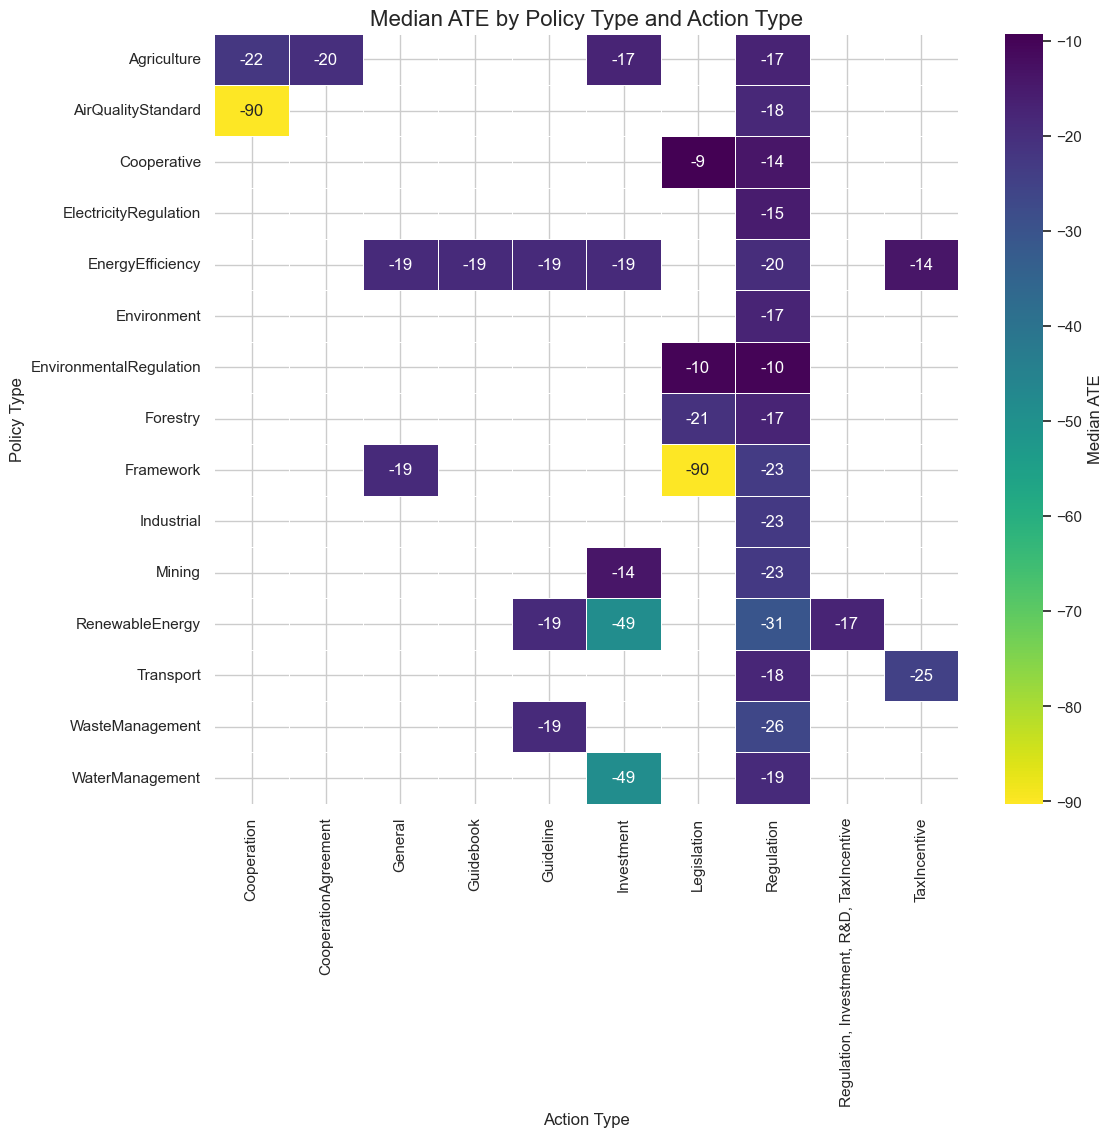

In [12]:
# --- 20. Create a Pivot Table for the Heatmap ---
# We want to see the median ATE for each combination
# We'll use our 'df_merged_broad' (all significant results)

# To make the chart readable, let's filter for the 
# Top 15 policy types and Top 10 action types by count
top_policies = df_merged_broad['policy_type'].value_counts().head(15).index
top_actions = df_merged_broad['action_type'].value_counts().head(10).index

# Filter the dataframe to only include these top categories
df_heatmap_data = df_merged_broad[
    (df_merged_broad['policy_type'].isin(top_policies)) &
    (df_merged_broad['action_type'].isin(top_actions))
]

# Create the pivot table (index=policy, columns=action, values=median ATE)
pivot_table = df_heatmap_data.pivot_table(
    values='ate',
    index='policy_type',
    columns='action_type',
    aggfunc='median' # Use median, as we learned
)

# --- 21. Plot the Heatmap ---
print("--- 📊 Heatmap: Median ATE by Policy Type vs. Action Type ---")

plt.figure(figsize=(12, 10))
sns.heatmap(
    pivot_table,
    annot=True,       # Add the ATE numbers to the cells
    fmt=".0f",        # Format numbers as integers
    cmap="viridis_r", # Use our "lower is better" colormap
    linewidths=.5,
    cbar_kws={'label': 'Median ATE'} # Label the color bar
)
plt.title('Median ATE by Policy Type and Action Type', fontsize=16)
plt.xlabel('Action Type', fontsize=12)
plt.ylabel('Policy Type', fontsize=12)
plt.show()